<a href="https://colab.research.google.com/github/beotavalo/geospatial-chat/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install python-docx rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.6 MB/s eta 0:00:00


In [56]:
import re
from docx import Document
import pandas as pd
from rapidfuzz import fuzz, process

# Definir áreas y palabras clave
areas = {
    "surveying": ["survey", "measurement", "boundary", "land", "property"],
    "mapping": ["map", "cartography", "GIS"],
    "remote sensing": ["satellite", "imagery", "remote sensing", "remote", "sensing", "sensor"],
    "geospatial intelligence": ["geospatial", "intelligence", "analysis"]
}

def classify_area(paragraph_text):
    for area, keywords in areas.items():
        if any(re.search(rf"\b{keyword}\b", paragraph_text, re.IGNORECASE) for keyword in keywords):
            return area
    return "other"

def extract_content_from_docx(file_path):
    document = Document(file_path)
    paragraphs = []
    current_title = None
    current_question = None

    # Búsqueda de preguntas con patrones de signos de interrogación
    question_pattern = re.compile(r'.*\?')

    for paragraph in document.paragraphs:
        text = paragraph.text.strip()
        if text:
            # Si es una pregunta, la identificamos
            if question_pattern.match(text):
                current_question = text
            # Si no es pregunta, se considera como párrafo de texto bajo un título/pregunta
            else:
                paragraphs.append({
                    'title': current_title,
                    'question': current_question,
                    'text': text
                })
                # Reiniciar pregunta una vez añadida
                current_question = None
    return paragraphs


def remove_similar_paragraphs(paragraphs, similarity_threshold=85):
    unique_paragraphs = []
    for p in paragraphs:
        is_unique = True
        for unique_p in unique_paragraphs:
            similarity = fuzz.ratio(p['text'], unique_p['text'])
            if similarity > similarity_threshold:
                is_unique = False
                break
        if is_unique:
            unique_paragraphs.append(p)
    return unique_paragraphs

def export_to_csv(paragraphs, output_file='output.csv'):
    data = [{'question': p['question'], 'area': p['area'], 'text': p['text']} for p in paragraphs]
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)

# Ejemplo de uso
file_path = '/content/geodocument.docx'
paragraphs = extract_content_from_docx(file_path)

# Añadir el área a cada párrafo
for p in paragraphs:
    p['area'] = classify_area(p['text'])

# Eliminar párrafos similares
cleaned_paragraphs = remove_similar_paragraphs(paragraphs)

# Guardar el contenido procesado
export_to_csv(cleaned_paragraphs)

                                            question       area  \
0                          1. What is a land survey?  surveying   
1              2. Why are land surveys so important?  surveying   
2                 3. How is a land survey performed?  surveying   
3  4. Why have I been asked if I want property ma...  surveying   
4  5. Why should I not waive the marking of prope...  surveying   

                                                text  
0  A land survey is a report in the form of a map...  
1  Prior to the closing on your new home purchase...  
2  The land surveyor's responsibility is to locat...  
3  In the course of performing a survey in New Je...  
4  Boundary lines shown on a survey map of the pr...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  113 non-null    object
 1   area      623 non-null    object
 2   text  

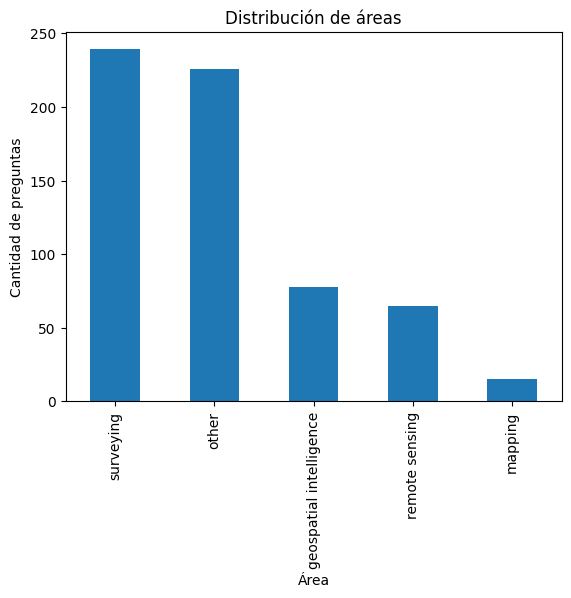

In [4]:
# prompt: read the output csv to perform EDA

import pandas as pd

# Leer el archivo CSV
df = pd.read_csv('output.csv')

# Mostrar las primeras filas del DataFrame
print(df.head())

# Obtener información general sobre los datos
print(df.info())

# Describir las variables numéricas
print(df.describe())

# Contar la cantidad de preguntas por área
print(df['area'].value_counts())

# Analizar la longitud de los textos
df['text_length'] = df['text'].apply(len)
print(df['text_length'].describe())

# Visualizar la distribución de las áreas
import matplotlib.pyplot as plt
df['area'].value_counts().plot(kind='bar')
plt.title('Distribución de áreas')
plt.xlabel('Área')
plt.ylabel('Cantidad de preguntas')
plt.show()


In [6]:
df.tail()

,question,area,text,text_length
618,Is Restb.ai an AVM?,other,"No, Restb.ai is not an Automated Valuation Mod...",108
619,Are you extracting images from PDFs?,other,"Yes, Restb.ai can extract images from PDFs.",43
620,Do you use humans to validate your results or ...,other,"No, these are AI generated results. We don’t h...",133
621,How long does it take to get results back from...,other,It is a real-time process and the results take...,71
622,How is Restb.ai Data different from any other ...,surveying,Restb.ai extracts unique information from the ...,517


In [40]:
#!/usr/bin/env python3

# file: test_so_search.py

import requests

if __name__ == "__main__":
    api_url = "https://api.stackexchange.com/2.3/search/excerpts"

    search_term = "remote sensing"
    qs = {
        "page": 1,
        "pagesize": 100,
        "order": "desc",
        "sort": "votes",
        "site": "gis",
        "q": search_term
    }

    rsp = requests.get(api_url, qs)

    data = rsp.json()

    print(f"Got {len(data['items'])} results for '{search_term}'")

Got 100 results for 'remote sensing'


In [41]:
# prompt: save data json on the name file must be the search_term

import json

# Save the data to a file named after the search term
with open(f'{search_term}.json', 'w') as f:
  json.dump(data, f, indent=4)


In [42]:
# prompt: concatenate all the json files in a document json

import json
import glob

def concatenate_json_files(output_file='concatenated.json'):
  """
  Concatenates all JSON files in the current directory into a single JSON file.
  """
  data = []
  for filename in glob.glob('*.json'):
    with open(filename, 'r') as f:
      try:
        file_data = json.load(f)
        data.extend(file_data['items'])  # Assuming 'items' is the key containing the data
      except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file {filename}: {e}")

  # Write the concatenated data to a new JSON file
  with open(output_file, 'w') as outfile:
    json.dump({'items': data}, outfile, indent=4)

# Call the function to concatenate the files
concatenate_json_files()


                                           tags  question_score  is_accepted  \
0                                        [data]              55         True   
1  [web-mapping, software-recommendations, php]              22        False   
2            [open-source-gis, arcgis-platform]              19        False   
3          [qgis, configuration, image-service]              14        False   
4                          [geoserver, hosting]              12        False   

   answer_id  is_answered  question_id item_type  score  last_activity_date  \
0     7760.0        False         7758    answer     38          1327621410   
1        NaN         True        13868  question     22          1501706794   
2        NaN         True        23556  question     19          1459310578   
3        NaN         True       231889  question     14          1544403675   
4        NaN         True        30491  question     12          1481121756   

   creation_date                            

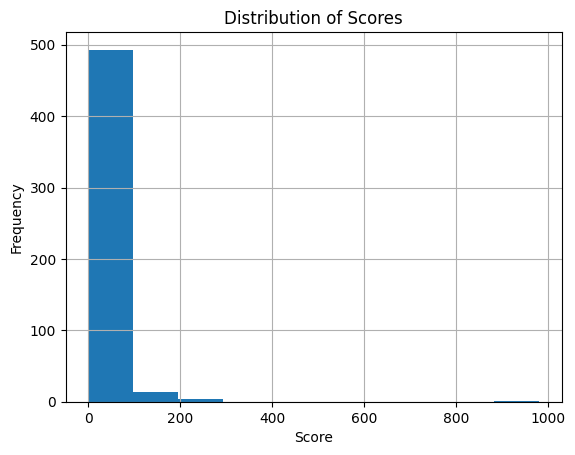

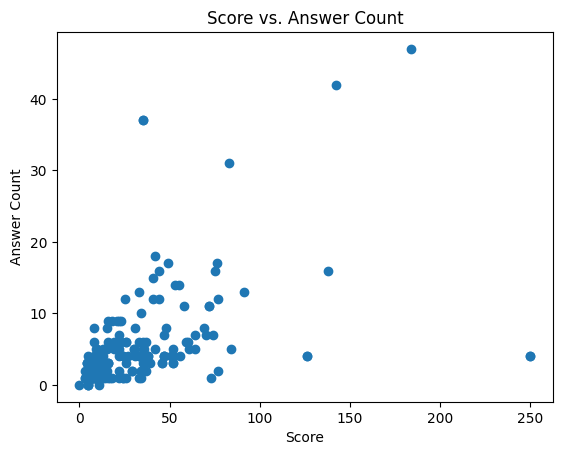

[('qgis', 72), ('remote-sensing', 46), ('web-mapping', 44), ('coordinate-system', 43), ('references', 37), ('software-recommendations', 35), ('python', 35), ('data', 28), ('shapefile', 24), ('open-source-gis', 23)]


In [43]:
# prompt: perform EDA for concatenated.json

import pandas as pd
import json

# Load the concatenated JSON data
with open('concatenated.json', 'r') as f:
  data = json.load(f)

# Extract the items from the JSON data
items = data['items']

# Create a Pandas DataFrame from the items
df = pd.DataFrame(items)


In [46]:
df.head()

,tags,question_score,is_accepted,answer_id,is_answered,question_id,item_type,score,last_activity_date,creation_date,body,excerpt,title,has_accepted_answer,answer_count
0,[data],55,True,7760.0,False,7758,answer,38,1327621410,1301095774,\nDiego Valle-Jones has done some interesting ...,"Wikinarco provides <span class=""highlight"">web...",The GIS of War - Tracking Conflicts and Their ...,NaN,NaN
1,"[web-mapping, software-recommendations, php]",22,False,NaN,True,13868,question,22,1501706794,1314025442,I&#39;m a recent Computer Science graduate who...,I&#39;ve been charged with developing (ie. cod...,Seeking developer-friendly web GIS?,True,5.0
2,"[open-source-gis, arcgis-platform]",19,False,NaN,True,23556,question,19,1459310578,1334594787,"I always wonder, why in GIS industry there are...","I always wonder, why in GIS industry there are...",Is GIS industry always ruled by two options on...,True,5.0
3,"[qgis, configuration, image-service]",14,False,NaN,True,231889,question,14,1544403675,1489421005,The USDA (via the National Map) provides 4-ban...,"An ArcGIS Online <span class=""highlight"">webma...",Configure which bands to display from a 4-band...,False,1.0
4,"[geoserver, hosting]",12,False,NaN,True,30491,question,12,1481121756,1343538841,"I am working with a non-profit, and we are pla...","I am working with a non-profit, and we are pla...","Are there any Hosting companies, that offer Ge...",True,4.0


In [54]:
# prompt: print the title, body and excerpt form the first row

print(df['title'][2])



Is GIS industry always ruled by two options only, namely Esri products and OSGeo projects?


In [55]:
print(df['body'][2])

I always wonder, why in GIS industry there are merely two major options available. Although there are many other proprietary software products for GIS, their market share is well below ESRI products (here, here and here although quite back dated). My opinion became stronger after joining GIS SE. Most of the questions, as well as the leading users (with highest reputation), are either for/interested in ESRI line of products or FOSS (of course apart from some questions related to data and theory). 

However this not the case in other streams of information technology, databases and programming languages in broad sense. I personally feel one reason could be the lack of interest by the software giants like Microsoft, Google or Oracle. While the first two have WebMaps, these are not WebGIS, and the spatial extension of Oracle is not fully GIS too. 

What are the major reasons for such a trend? There is nice article somewhat related to this, &quot; The Five Major Roadblocks to GIS Gaining Co

In [52]:
print(df['excerpt'][0])

Wikinarco provides <span class="highlight">webmap</span> interface to some drug related crime statistics in Mexico. &hellip; 


In [ ]:

# Perform Exploratory Data Analysis (EDA)

# Display the first few rows of the DataFrame
print(df.head())

# Get information about the DataFrame
print(df.info())

# Describe the numerical features
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Analyze the distribution of 'score'
df['score'].hist()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

# Analyze the relationship between 'score' and 'answer_count'
plt.scatter(df['score'], df['answer_count'])
plt.xlabel('Score')
plt.ylabel('Answer Count')
plt.title('Score vs. Answer Count')
plt.show()

# Analyze the most frequent tags
from collections import Counter
all_tags = [tag for row in df['tags'] for tag in row]
tag_counts = Counter(all_tags)
print(tag_counts.most_common(10))  # Print the 10 most common tags

# Further analysis can be done based on specific needs and insights


In [57]:
# prompt: concatenar el archivo output csv y el archivo concatenated.json en un solo json los campos corresponden [title:question, body+excerpt: text, area:tag] sacar solamente esos tres campos en un solo json

import pandas as pd
import json

# Load the CSV data
df_csv = pd.read_csv('output.csv')

# Load the JSON data
with open('concatenated.json', 'r') as f:
  data_json = json.load(f)

# Extract relevant data from JSON
df_json = pd.DataFrame(data_json['items'])
df_json = df_json[['title', 'body', 'excerpt', 'tags']]
df_json['body'] = df_json['body'] + ' ' + df_json['excerpt']
df_json = df_json.rename(columns={'title': 'question', 'body': 'text', 'tags': 'area'})
df_json = df_json[['question', 'text', 'area']]

# Concatenate the DataFrames
df_combined = pd.concat([df_csv, df_json], ignore_index=True)

# Convert the combined DataFrame to a list of dictionaries
result = df_combined.to_dict('records')

# Save the combined data to a JSON file
with open('combined_data.json', 'w') as f:
  json.dump(result, f, indent=4)


                                            question       area  \
0                          1. What is a land survey?  surveying   
1              2. Why are land surveys so important?  surveying   
2                 3. How is a land survey performed?  surveying   
3  4. Why have I been asked if I want property ma...  surveying   
4  5. Why should I not waive the marking of prope...  surveying   

                                                text  
0  A land survey is a report in the form of a map...  
1  Prior to the closing on your new home purchase...  
2  The land surveyor's responsibility is to locat...  
3  In the course of performing a survey in New Je...  
4  Boundary lines shown on a survey map of the pr...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  624 non-null    object
 1   area      1134 non-null   object
 2   text

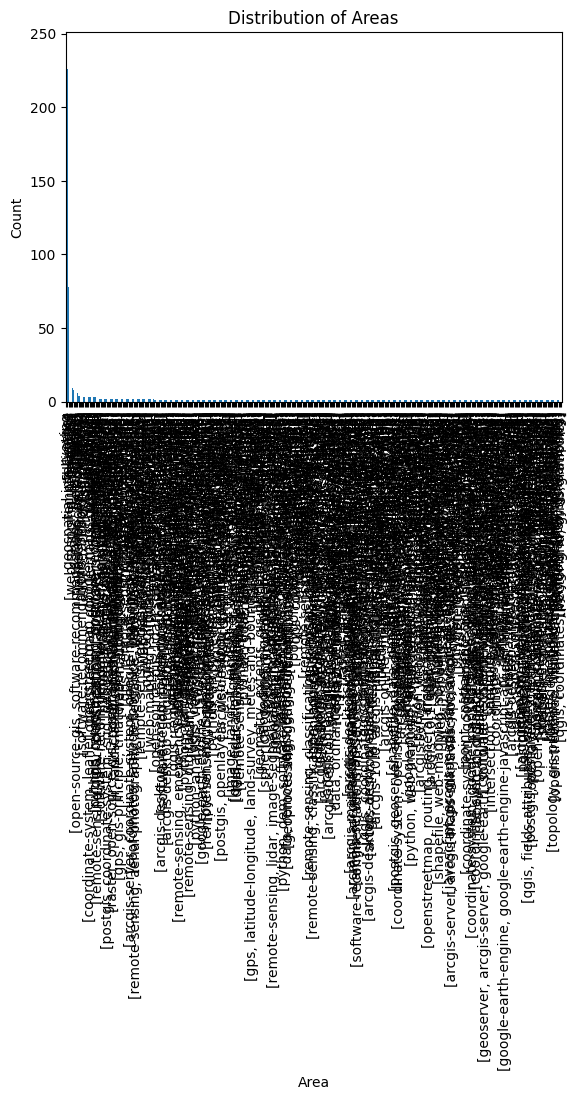

count     1134.000000
mean       875.494709
std       1238.384081
min          1.000000
25%        186.000000
50%        405.000000
75%       1106.500000
max      11353.000000
Name: text_length, dtype: float64


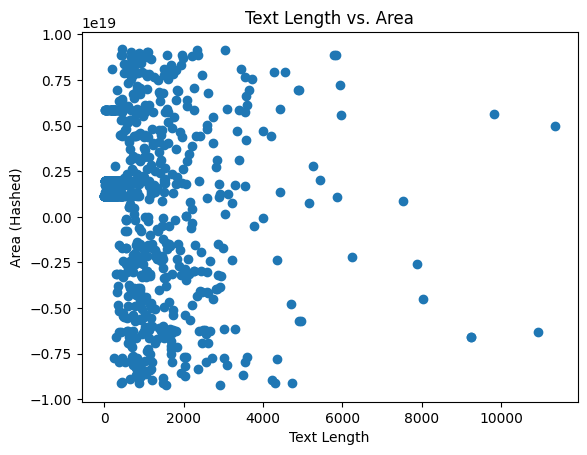

In [58]:
# prompt: perform eda for combined data

import pandas as pd

# Load the combined data from the JSON file
with open('combined_data.json', 'r') as f:
  data = json.load(f)

# Create a Pandas DataFrame from the loaded data
df_combined = pd.DataFrame(data)

# Perform Exploratory Data Analysis (EDA)

# Display the first few rows of the DataFrame
print(df_combined.head())

# Get information about the DataFrame
print(df_combined.info())

# Describe the numerical features
print(df_combined.describe())

# Check for missing values
print(df_combined.isnull().sum())

# Analyze the distribution of 'area'
df_combined['area'].value_counts().plot(kind='bar')
plt.xlabel('Area')
plt.ylabel('Count')
plt.title('Distribution of Areas')
plt.show()

# Analyze the length of the text
df_combined['text_length'] = df_combined['text'].apply(len)
print(df_combined['text_length'].describe())

# Analyze the relationship between text length and area
plt.scatter(df_combined['text_length'], df_combined['area'].apply(lambda x: hash(str(x))))
plt.xlabel('Text Length')
plt.ylabel('Area (Hashed)')
plt.title('Text Length vs. Area')
plt.show()

# Further analysis can be done based on specific needs and insights


In [60]:
df_combined.tail()

,question,area,text,text_length
1129,What to consider when hiring aerial LiDAR survey?,"[data, lidar, canada, business, land-survey]",My organization is considering hiring a compan...,1426
1130,Capturing accurate GPS points using mobile dev...,"[gps, android, mobile, ios]",I&#39;m currently working in Vietnam as a cli...,1451
1131,Label placement on rotated map in QGIS,"[qgis, labeling]",I&#39;m a newbie to GIS and QGIS (please be ni...,2621
1132,Raster incorrectly reprojected to OSGB(27700) ...,"[qgis, coordinate-system]",There was a lot of discussion on that lately:\...,2035
1133,Creating grid in QGIS &#39;anchored&#39; to sp...,"[qgis, coordinates, vector-grid, grids-graticu...",I need to create grids using QGIS with specifi...,724
